In [1]:
%matplotlib inline

###KAUFMAN LAB LIBRARY
# klib_version = '1.1'

import sys
# sys.path.append('../../Analysis_code/klab_python_lib_Yb/')

# import klib
# if klib.__version__ != klib_version:
#     raise ValueError('Incorrect klib version number.')

# from klib.imports import *
# from klib.analysis import *
# from klib.plotutil import *
# from klib.zynq_client import *

# from vimba import *
from IPython import display
import time
# from pymba import Vimba, VimbaException, Frame

%load_ext autoreload
# %aimport klib
%autoreload

In [2]:
from ctypes import *
import pythoncom

gmoogLib = cdll.LoadLibrary("./x64/Release/gmoogLib.dll")

class GM_python(object):
    def __init__(self):
        gmoogLib.gm_new.argtypes = []
        gmoogLib.gm_new.restype = c_void_p
        
        gmoogLib.gm_test.argtypes = [c_void_p]
        gmoogLib.gm_test.restype = c_int
        
        gmoogLib.gm_zeroAll.argtypes = [c_void_p]
        gmoogLib.gm_zeroAll.restype = c_void_p
        
        gmoogLib.gm_endMessage.argtypes = [c_void_p]
        gmoogLib.gm_endMessage.restype = c_void_p
        
        gmoogLib.gm_setDAC.argtypes = [c_void_p, c_int, c_int, POINTER(c_float), POINTER(c_float), POINTER(c_float)]
        gmoogLib.gm_setDAC.restype = c_void_p
        
        self.obj = gmoogLib.gm_new()
    
    def test(self):
        gmoogLib.gm_test(self.obj)
    def zeroAll(self):
        gmoogLib.gm_zeroAll(self.obj)
    def endMessage(self):
        gmoogLib.gm_endMessage(self.obj)
    def setDAC(self, dac, channels, freqs, amps, phases):
        gmoogLib.gm_setDAC(self.obj, dac, channels, freqs, amps, phases)

gmoog = GM_python()

In [3]:
gmoog.test()

In [4]:
%autoreload

# Starting point for generating tones

##813

# numtones0 = 16
# numtones1 = 20

# bgoff = (165, 165)

# DACoffset = 2
# amp_guessD0 = 70
# amp_guessD1 = 70

# lincorr0 = 0
# lincorr1 = 0

# freqcenterD0 = 180+3-0.5
# spacingD0 = 5*0.6377
# freqcenterD1 = 190+.2
# spacingD1 = 4*0.6377

##813 NEW 210220

# numtones0 = 6
# numtones1 = 6

# bgoff = (165, 165)

# DACoffset = 2
# amp_guessD0 = 70
# amp_guessD1 = 80

# lincorr0 = 0
# lincorr1 = 0

# latspacing = 5.6575*(30/29+1/128)/4*0.6377

# freqcenterD0 = 180
# freqcenterD1 = 180

# # freqcenterD0 = 180+3-0.5
# # freqcenterD1 = 190+.2-5*.6377

# spacingD0 = latspacing*11
# spacingD1 = latspacing*11

# ###515

# numtones0 = 16
# numtones1 = 16

numtones0 = 4
numtones1 = 4


bgoff = (165, 165)

DACoffset = 0
# amp_guessD0 = 90
# amp_guessD1 = 80
amp_guessD0 = 80
amp_guessD1 = 80

lincorr0 = 0
lincorr1 = 0

# freqcenterD0 = 180
# spacingD0 = 60 # 4.5 #10
# freqcenterD1 = 180
# spacingD1 = 65 # 4 #16

#latspacing = 5.6575*(30/29+1/128)/3

# freqcenterD0 = 180
freqcenterD0 = 82
spacingD0 = 2.5
# freqcenterD1 = 175
freqcenterD1 = 82
spacingD1 = 3

###

# offset = 1.3
double = False #BE VERY CAREFUL - CAN QUADRUPLE EXPECTED OUTPUT POWER IF SET TO TRUE.

tone_inds0 = np.arange(numtones0)
tone_inds1 = np.arange(numtones1)

freqsD0 = np.arange(freqcenterD0-spacingD0*(numtones0-1)/2, freqcenterD0+spacingD0*numtones0/2, spacingD0)
freqsD1 = np.arange(freqcenterD1-spacingD1*(numtones1-1)/2, freqcenterD1+spacingD1*numtones1/2, spacingD1)

print(freqsD0)

phases0 = np.pi*((tone_inds0+1)**2)/(numtones0)
phases1 = np.pi*((tone_inds1+1)**2)/(numtones1)

phase_degs0 = np.round(phases0*180/np.pi%360, 1)
phase_degs1 = np.round(phases1*180/np.pi%360, 1)

ampscale = .001

init_ampsD0 = np.ones(numtones0)*amp_guessD0 + (np.arange(numtones0)-numtones0/2)*lincorr0
init_ampsD1 = np.ones(numtones1)*amp_guessD1 + (np.arange(numtones1)-numtones1/2)*lincorr1

ampD0 = init_ampsD0
ampD1 = init_ampsD1
err = 50

seq0 = c_float * numtones0
seq1 = c_float * numtones1

gmoog.zeroAll()

if double:
    amp100 = np.ones(numtones)*100
    seq = c_float * (2 * numtones)
    freqsetDD0 = np.concatenate((freqsD0,freqsD0))
    freqsetDD1 = np.concatenate((freqsD1,freqsD1))

    ampsetDD0 = np.concatenate((amp100, ampD0))
    ampsetDD1 = np.concatenate((amp100, ampD1))

    phasesetD0 = np.concatenate((phase_degs0, phase_degs0))
    phasesetD1 = np.concatenate((phase_degs1, phase_degs1))
    gmoog.setDAC(0+DACoffset, 2*numtones, seq(*freqsetDD0), seq(*ampsetDD0), seq(*phasesetD0))
    gmoog.setDAC(1+DACoffset, 2*numtones, seq(*freqsetDD1), seq(*ampsetDD1), seq(*phasesetD1))
else:
    gmoog.setDAC(0+DACoffset, len(freqsD0), seq0(*freqsD0), seq0(*ampD0), seq0(*phase_degs0))
    gmoog.setDAC(1+DACoffset, len(freqsD1), seq1(*freqsD1), seq1(*ampD1), seq1(*phase_degs1))

gmoog.endMessage()

time.sleep(.2)

if double:
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, amp100[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, amp100[ind], freqsD1[ind], phase_degs1[ind])
    
    print()
    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind + np.max(tone_inds) + 1, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind + np.max(tone_inds) + 1, ampD1[ind], freqsD1[ind], phase_degs1[ind])

else:    
    for ind in tone_inds0:
        print('set', "DAC"+str(0+DACoffset), ind, ampD0[ind], freqsD0[ind], phase_degs0[ind])

    print()

    for ind in tone_inds1:
        print('set', "DAC"+str(1+DACoffset), ind, ampD1[ind], freqsD1[ind], phase_degs1[ind])

[78.25 80.75 83.25 85.75]
set DAC0 0 80.0 78.25 45.0
set DAC0 1 80.0 80.75 180.0
set DAC0 2 80.0 83.25 45.0
set DAC0 3 80.0 85.75 0.0

set DAC1 0 80.0 77.5 45.0
set DAC1 1 80.0 80.5 180.0
set DAC1 2 80.0 83.5 45.0
set DAC1 3 80.0 86.5 0.0


In [129]:
zynq = zynq_tcp_client()
zynq.connect()
zynq.triggerGigamoogWithTweezersOn()
zynq.disconnect()

In [72]:
freqsD0

array([82.])

In [73]:
freqsD1

array([82.])

# setup the camera and masks

In [143]:
zynq = zynq_tcp_client()
zynq.connect()
zynq.triggerGigamoogWithTweezersOn()
zynq.disconnect()
camID = 0
cam_settings_file = "tweezer_monitor_singleFrame.xml"
crop_coords = arr([0, -1, 0, -1])
imgs = []
with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    with cams[camID] as cam:
        cam.load_settings(cam_settings_file, PersistType.All)
        cam.TriggerSource.set('Software')
        cam.TriggerSelector.set('FrameStart')
        cam.TriggerMode.set('On')
        cam.AcquisitionMode.set('SingleFrame')
        exposure_time = cam.ExposureTime
        exposure_time.set(exposure)
        for i in range(10):
            cam.start_streaming(handler)
            cam.TriggerSoftware.run()
            cam.stop_streaming ()
            img = getImgSoftwareTrigger(frames[-1], crop_coords)
            imgs.append(img)

imgc = imgs[0]

Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee07012040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee12a17040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee1f32e040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee23c8c040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee25b3d040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee29c6f040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee27e48040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee2a454040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee31162040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee4b148040)


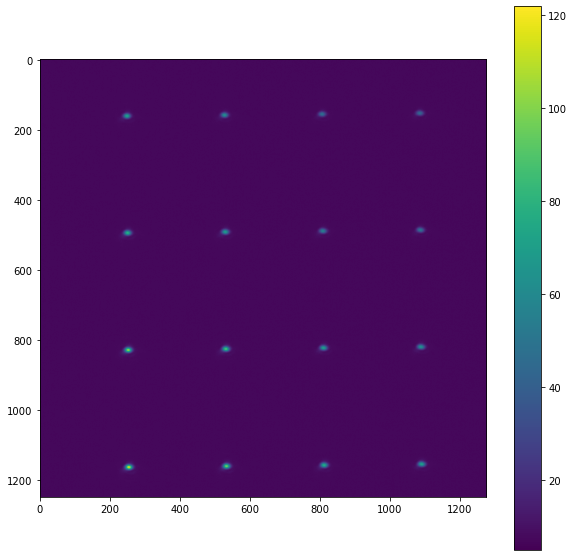

In [131]:
plt.imshow(np.array(imgs[0], dtype=float))
plt.colorbar()

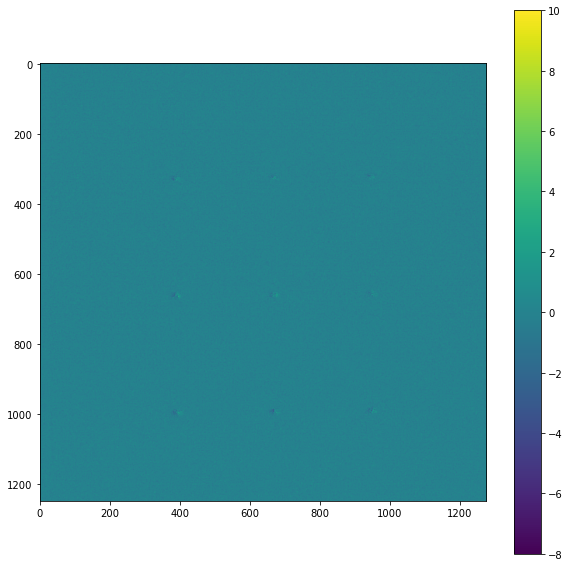

In [10]:
plt.imshow(np.array(imgs[3], dtype=float)-np.array(imgs[0], dtype=float))
plt.colorbar()

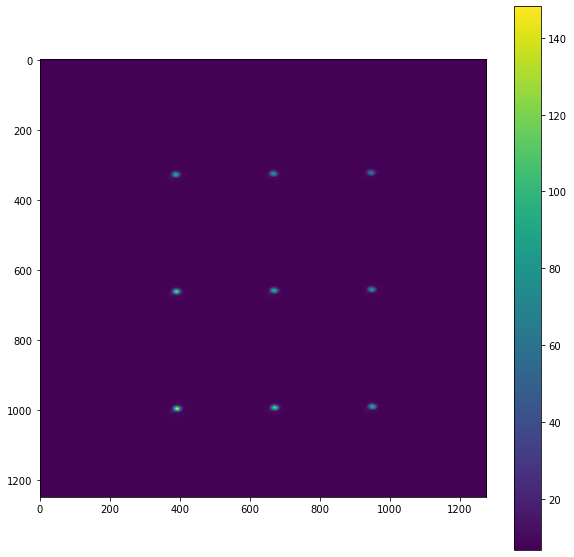

In [11]:
plt.imshow(np.mean(np.array(imgs, dtype=float), axis=0))
plt.colorbar()

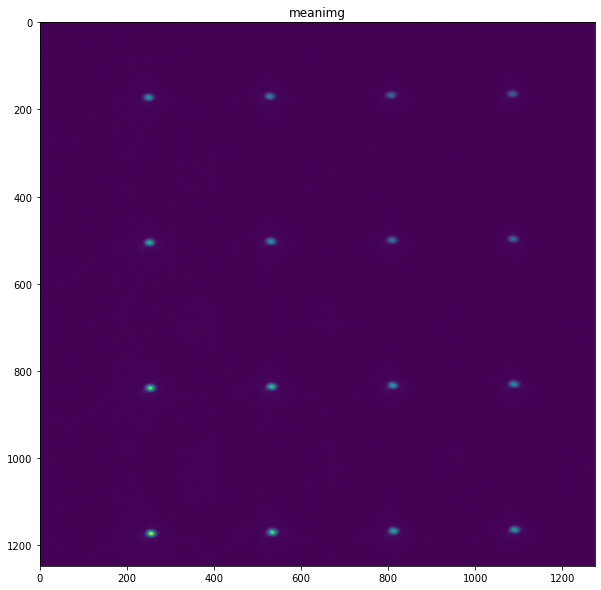

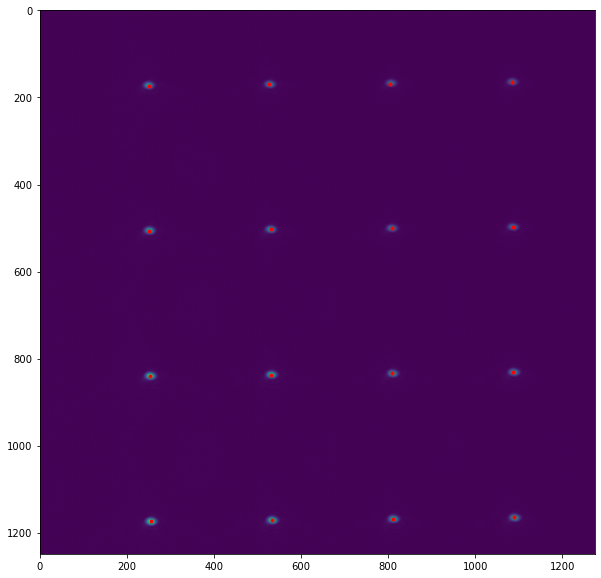

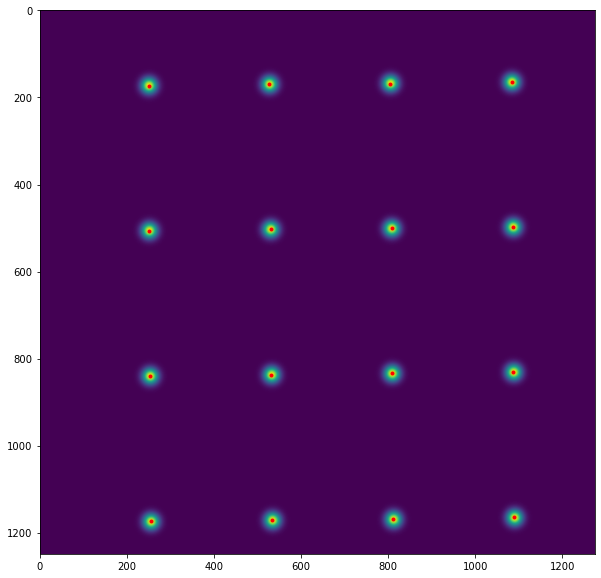

In [144]:
imgc = np.mean(np.array(imgs, dtype=float), axis=0)

bg = np.mean(imgc)
meanimg = imgc - bg

plt.imshow(meanimg)
plt.title("meanimg")
plt.show()

masks = getMasks(meanimg, wmask=25, N=4, fftN=3600, mode = "gauss", FFT=False, peakParams = [30,30])

In [145]:
np.shape(masks)

(16, 1249, 1275)

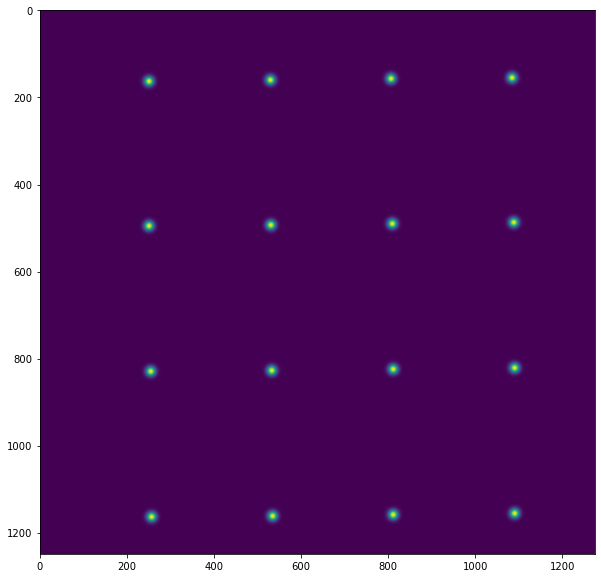

In [112]:
plt.imshow(np.mean(np.delete(masks,[13],axis=0),axis=0))

In [113]:
masks = np.delete(masks,[13],axis=0)

In [114]:
np.shape(masks)

(16, 1249, 1275)

# do the optimization here

In [159]:
zynq = zynq_tcp_client()
zynq.connect()

err=30

with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    with cams[camID] as cam:
        cam.load_settings(cam_settings_file, PersistType.All)
        cam.TriggerSource.set('Software')
        cam.TriggerSelector.set('FrameStart')
        cam.TriggerMode.set('On')
        cam.AcquisitionMode.set('SingleFrame')
        exposure_time = cam.ExposureTime
        exposure_time.set(exposure)
        while err > 10:
            zynq.triggerGigamoogWithTweezersOn()
            cam.start_streaming(handler)
            cam.TriggerSoftware.run()
            cam.stop_streaming()
            img = getImgSoftwareTrigger(frames[-1], crop_coords)
            ampD0, ampD1, err = getNewAmps(img, ampD0, ampD1, freqsD0, freqsD1, phase_degs0, phase_degs1, masks, method='mean', ampscale = 0.01, DACoffset = DACoffset, double = double)
            print(ampD0, ampD1, err)
        print('Switch mode')

        while err > 2.5:
            cam.start_streaming(handler)
            zynq.triggerGigamoogWithTweezersOn()
            cam.TriggerSoftware.run()
            cam.stop_streaming()
            img = getImgSoftwareTrigger(frames[-1], crop_coords)
            ampD0, ampD1, err = getNewAmps(img, ampD0, ampD1, freqsD0, freqsD1, phase_degs0, phase_degs1, masks, method='randomCross', ampscale = 0.003, DACoffset = DACoffset, double = double)
            print(ampD0, ampD1, err)
        print('End')

zynq.triggerGigamoogWithTweezersOn()
zynq.disconnect()

Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee4d287040)
[68.17929631 74.13075986 86.02938552 91.6605583 ] [68.99377258 72.4492795  85.31320646 93.24374146] 3.459717390847847
Switch mode
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee51f50040)
[68.17213777 74.10543779 86.03340488 91.68901956] [68.9984518  72.45033117 85.30096422 93.25025281] 3.0963414943820076
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee57d10040)
[68.15407415 74.09699294 86.04770269 91.70123022] [68.9640154  72.43848029 85.33062719 93.26687713] 3.1619584601507085
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee5cecd040)
[68.14646298 74.07527541 86.04841446 91.72984715] [68.93337379 72.42635565 85.35752613 93.28274443] 2.83410790961619
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x2ee5f17f040)
[68.14919881 74.07574618 86.04849531 91.7265597 ] [68.90064715 72.41666814 85.38107946 93.30160525] 3.01796264524005
Fra

In [18]:
getNewAmps(img, ampD0, ampD1, freqsD0, freqsD1, phase_degs0, phase_degs1, masks, method='randomCross', ampscale = 0.0001, DACoffset = DACoffset, double = double)

(array([72.2736162 , 79.58258001, 88.14380379]),
 array([72.01670991, 79.05771683, 88.92557326]),
 3.890228045765031)

# write freqs, phases, amps to a text file

In [19]:
gigamoogValues = ""

for i in range(len(freqsD0)):
    gigamoogValues += "set DAC0 {:d} {:.5f} {:.5f} {:.5f}\n".format(i, ampD0[i], freqsD0[i], phase_degs0[i])

gigamoogValues += "\n"

for i in range(len(freqsD1)):
    gigamoogValues += "set DAC1 {:d} {:.5f} {:.5f} {:.5f}\n".format(i, ampD1[i], freqsD1[i], phase_degs1[i])

In [20]:
print(gigamoogValues)

set DAC0 0 72.30629 79.50000 60.00000
set DAC0 1 79.59043 82.00000 240.00000
set DAC0 2 88.10327 84.50000 180.00000

set DAC1 0 72.04503 79.00000 60.00000
set DAC1 1 79.03102 82.00000 240.00000
set DAC1 2 88.92396 85.00000 180.00000



In [21]:
gigamoogValues_file = open("gigamoogValues.txt", "w")
gigamoogValues_file.write(gigamoogValues)
gigamoogValues_file.close()

# test fast images

In [20]:
zynq = zynq_tcp_client()
zynq.connect()
zynq.triggerGigamoogWithTweezersOn()
zynq.disconnect()
camID = 0
cam_settings_file = "tweezer_monitor_singleFrame.xml"
crop_coords = arr([100, 1320, 200, 1050])
imgs = []
exposure = 20
with Vimba.get_instance() as vimba:
    cams = vimba.get_all_cameras()
    with cams[camID] as cam:
        cam.load_settings(cam_settings_file, PersistType.All)
        cam.TriggerSource.set('Software')
        cam.TriggerSelector.set('FrameStart')
        cam.TriggerMode.set('On')
        cam.AcquisitionMode.set('SingleFrame')
        exposure_time = cam.ExposureTime
        exposure_time.set(exposure)
        for i in range(50):
            cam.start_streaming(handler)
            cam.TriggerSoftware.run()
            cam.stop_streaming ()
            img = getImgSoftwareTrigger(frames[-1], crop_coords)
            imgs.append(img)

Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2a601c040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2aa3df040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2ac84c040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2acd05040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2ae985040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2afc8a040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2b1941040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2b2930040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2bb00d040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2bbcac040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2bc940040)
Frame acquired: Frame(id=0, status=FrameStatus.Complete, buffer=0x1b2bd456040)
Frame acquired: Frame(id=0, status=FrameStatus.Compl

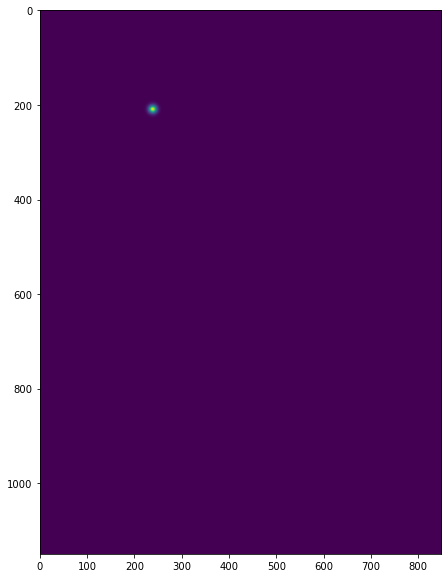

In [21]:
plt.imshow(imgs[0]*masks[0])

In [24]:
msums = []
for i in range(len(imgs)):
    msum = []
    for j in range(len(masks)):
        msum.append(np.sum(imgs[i]*masks[j]))
    msums.append(msum)

In [26]:
msums = np.array(msums)

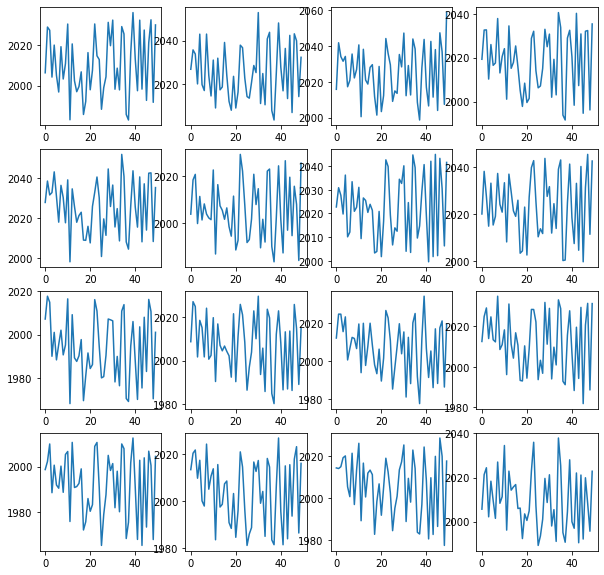

In [30]:
fig, ax_ = plt.subplots(ncols=4,nrows=4)
ax = ax_.flatten()
for m in range(len(masks)):
    ax[m].plot(msums[:,m])